In [35]:
import sys, os
# from http://stackoverflow.com/questions/595305/python-path-of-script
pathname = "~/QuantAnalysis/analysis_scripts"
sys.path.append(os.path.sep.join(['..', 'analysis_utils']))
sys.path.append(os.path.sep.join(['..', 'plotting_utils']))

import ParsingUtils
import AnalysisUtils

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [38]:
reload(ParsingUtils)

sims = os.path.sep.join([pathname, '..', 'sims', 'doi_10.1101_025387', 'dmel'])

rdict = {}
corrs = {}
for i in xrange(1, 7):
    path = os.path.sep.join([sims, str(i)])
    print("reading results from {}".format(path))
    tdf = ParsingUtils.readThreeColumnTruth(os.path.sep.join([path, "truth.tsv"]) , "_true")
    kdf = ParsingUtils.readKallisto(os.path.sep.join([path, "abundance.tsv"]), "_kallisto")
    sdf = ParsingUtils.readSailfish(os.path.sep.join([path, "quant.sf"]), "_sailfish")
    df = tdf.join(kdf, rsuffix="_K").join(sdf, rsuffix="_S")

    for method in ["sailfish", "kallisto"]:
        for ct in ["spearman", "pearson"]:
            corrKey = "{}_{}".format(method, ct)
            corr = df["TPM_true"].corr(df["TPM_{}".format(method)], method=ct)
            if corrKey in corrs:
                corrs[corrKey].append(corr)
            else:
                corrs[corrKey] = [corr] 

    rdict[i] = df

reading results from ~/QuantAnalysis/analysis_scripts/../sims/doi_10.1101_025387/dmel/1
reading results from ~/QuantAnalysis/analysis_scripts/../sims/doi_10.1101_025387/dmel/2
reading results from ~/QuantAnalysis/analysis_scripts/../sims/doi_10.1101_025387/dmel/3
reading results from ~/QuantAnalysis/analysis_scripts/../sims/doi_10.1101_025387/dmel/4
reading results from ~/QuantAnalysis/analysis_scripts/../sims/doi_10.1101_025387/dmel/5
reading results from ~/QuantAnalysis/analysis_scripts/../sims/doi_10.1101_025387/dmel/6


## Show the correlations

In [39]:
corrStrs = []
for k, v in corrs.iteritems():
    corrStrs.append("{}: {}".format(k, ','.join(["{:0.2}".format(c) for c in v])))
corrStrs = sorted(corrStrs)
print('\n'.join(corrStrs))


kallisto_pearson: 0.97,0.98,0.96,0.98,0.97,0.95
kallisto_spearman: 0.98,0.98,0.98,0.98,0.98,0.98
sailfish_pearson: 0.94,0.97,0.9,0.95,0.93,0.81
sailfish_spearman: 0.98,0.98,0.98,0.98,0.98,0.98


## Gather the relative differences

In [40]:
 relDiffs = {} 
for k,v in rdict.iteritems():
    rds = AnalysisUtils.relDiff("TPM_true", "TPM_sailfish", v, verbose=False)
    rdk = AnalysisUtils.relDiff("TPM_true", "TPM_kallisto", v, verbose=False)
    for method, rd in {"sailfish" : rds, "kallisto" : rdk}.iteritems():
        for summaryName, summaryFunc in {"median" : AnalysisUtils.getMedian, "mean" : AnalysisUtils.getMean}.iteritems(): 
            signedKey = "{}_{}_{}".format(method, summaryName, "signed")
            absKey = "{}_{}_{}".format(method, summaryName, "abs")
            if signedKey in relDiffs:
                relDiffs[signedKey].append(summaryFunc(rd[0]))
            else:
                relDiffs[signedKey] = [summaryFunc(rd[0])]
            if absKey in relDiffs:
                relDiffs[absKey].append(summaryFunc(rd[0].abs()))
            else: 
                relDiffs[absKey] = [summaryFunc(rd[0].abs())]


## Now print the relative difference metrics

In [41]:
for signedness in ["signed", "abs"]:
    for stat in ["median", "mean"]:
        if stat == "median":
            print("mean of medians of {} relative differences is :\n kallisto: {:0.2f}\n sailfish: {:0.2f}\n".format(
                signedness, np.mean(relDiffs["kallisto_{}_{}".format(stat, signedness)]),
                np.mean(relDiffs["sailfish_{}_{}".format(stat, signedness)])))
        elif stat == "mean":
             print("median of means of {} relative differences is :\n kallisto: {:0.2f}\n sailfish: {:0.2f}\n".format(
                signedness, np.median(relDiffs["kallisto_{}_{}".format(stat, signedness)]),
                np.median(relDiffs["sailfish_{}_{}".format(stat, signedness)])))


mean of medians of signed relative differences is :
 kallisto: -0.04
 sailfish: -0.03

median of means of signed relative differences is :
 kallisto: -0.04
 sailfish: -0.03

mean of medians of abs relative differences is :
 kallisto: 0.09
 sailfish: 0.08

median of means of abs relative differences is :
 kallisto: 0.29
 sailfish: 0.29



## Now, look in a bit more detail at the first simulation

In [42]:
rdk, nz = AnalysisUtils.relDiff('TPM_true', 'TPM_kallisto', rdict[1])
rds, nz = AnalysisUtils.relDiff('TPM_true', 'TPM_sailfish', rdict[1])

Plot the (signed) relative differences for all transcripts

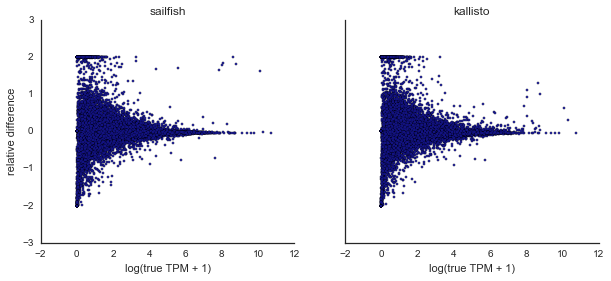

In [43]:
%matplotlib inline
sns.set_style('white')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(np.log(rdict[1]['TPM_true'].values + 1.0), rds.values, marker='.', c=(0.1, 0.1, 0.7))
ax2.scatter(np.log(rdict[1]['TPM_true'].values + 1.0), rdk.values, marker='.', c=(0.1, 0.1, 0.7))
sns.despine()
ax1.set_xlabel('log(true TPM + 1)')
ax2.set_xlabel('log(true TPM + 1)')
ax1.set_ylabel('relative difference')
ax1.set_title('sailfish')
ax2.set_title('kallisto')
f.set_size_inches(10, 4)

Plot the (absolute) relative differences for all transcripts

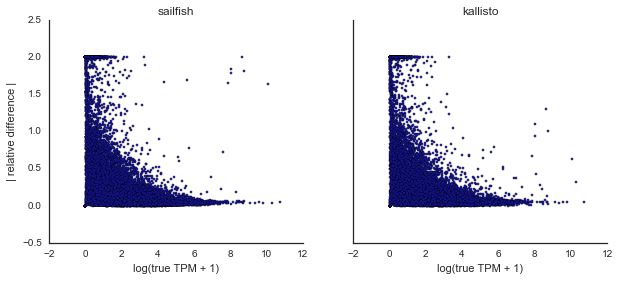

In [44]:
sns.set_style('white')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(np.log(rdict[1]['TPM_true'].values + 1.0), rds.abs().values, marker='.', c=(0.1, 0.1, 0.7))
ax2.scatter(np.log(rdict[1]['TPM_true'].values + 1.0), rdk.abs().values, marker='.', c=(0.1, 0.1, 0.7))
sns.despine()
ax1.set_xlabel('log(true TPM + 1)')
ax2.set_xlabel('log(true TPM + 1)')
ax1.set_ylabel('| relative difference |')
ax1.set_title('sailfish')
ax2.set_title('kallisto')
f.set_size_inches(10, 4)

Finally, just take a look at the scatter plot of the actual TPMs

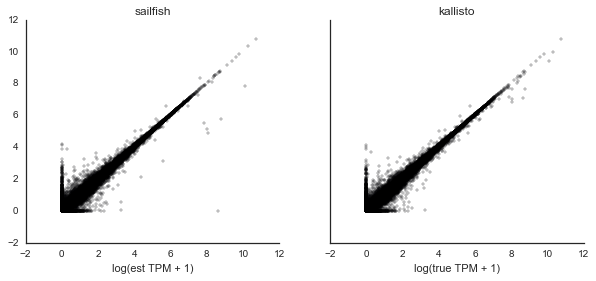

In [45]:
sns.set_style('white')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(np.log(rdict[1]['TPM_true']+1), np.log(rdict[1]['TPM_sailfish']+1), marker='.', c=(0.1, 0.1, 0.5, 0.01))
ax2.scatter(np.log(rdict[1]['TPM_true']+1), np.log(rdict[1]['TPM_kallisto']+1), marker='.', c=(0.1, 0.1, 0.5, 0.01))
ax1.set_xlabel('log(true TPM + 1)')
ax2.set_xlabel('log(true TPM + 1)')
ax1.set_xlabel('log(est TPM + 1)')
ax1.set_title('sailfish')
ax2.set_title('kallisto')
sns.despine()
f.set_size_inches(10, 4)